**This notebook generates pairs of matching and mismatching quarters with the following characteristics:**
* Each quarter pair is a left-right pair with the outer border of the prostate on the top
* The dataset is balanced (equal number of matching and mismatching pairs)
* The quarters from all mismatching pairs are generated from the same full slice

**Description of the algorithm:**
* Look only at fragments cut at angles 0-144 degrees (other angles are redundant)
* For each cut, get 8 pairs of matching images:
    * 4 pairs of neighboring quarters
    * Rotate them such that each is a left upper - right upper pair (upper half of prostate slice)
    * Generate horizontal flips and add to the data -> 4 additional pairs
* For each cut, get 8 pairs of mismatches:
    * 2 x (lu + rl), 2 x (ru + ll), 4 neighboring quarters at wrong borders

In [144]:
from PIL import Image
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from typing import Dict, Iterable, Callable, List


class QuarterPairsDataset(Dataset):
    """ Dataset class for matching and mismatching pairs of prostate slice quarters.
    
    TODO: Add
     * Padding at the borders
     * Border degradation
     * Slight rotations
     * Slight shifts
     * Possibly remove all image area outside of a mask
    
    """

    def __init__(self, img_dir:Path, list_IDs:np.array, transform=None, to_tensor:bool = True):
        self.img_dir = img_dir
        self.list_IDs = list_IDs
        self.transform = transform
        self.to_tensor = to_tensor

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, idx):
        """ Generate a pair of quarters.
        
        Each pair of quarters has the following characteristics:
        * Each pair of quarters is a left-right pair with the outer edge of the prostate
          on top (corresponding to the upper half of a full prostate slice)
        * The dataset is balanced: Equal probability of generating a matching and mismatching
          pair of quarters
        * The quarters of each mismatching pair come from the same prostate slice
        
        """
        
        # Randomly select slice id, rotation angle, and whether this will be a match or mismatch
        slice_id = np.random.choice(list_IDs)
        rotation_choice = np.random.choice(np.array([0, 36, 72, 108, 144]))
        target = np.array([np.random.choice([0,1])])
        
        if target == 1:
            # create match
            flip_horizontally = np.random.choice(np.array([0, 1]))
            matching_pair_options = np.array([['lu', 'ru'],
                                              ['ru', 'rl'],
                                              ['rl', 'll'],
                                              ['ll', 'lu']
                                             ])
            
            # randomly select a pair of neighboring quarters (top, right, bottom, or left)
            idx_choice = np.random.choice(np.array([0, 1, 2, 3]))
            pair_choice = matching_pair_options[idx_choice]
            img1 = Image.open(self.img_dir / f"{slice_id}_{rotation_choice}_{pair_choice[0]}.jpeg").resize((256,256), resample=Image.Resampling.BILINEAR)
            img2 = Image.open(self.img_dir / f"{slice_id}_{rotation_choice}_{pair_choice[1]}.jpeg").resize((256,256), resample=Image.Resampling.BILINEAR)
            
            # rotate such that both quarters are on the top
            if idx_choice == 1:
                img1, img2 = img1.rotate(angle=90), img2.rotate(angle=90)
            elif idx_choice == 2:
                img1, img2 = img1.rotate(angle=180), img2.rotate(angle=180)
            elif idx_choice == 3:
                img1, img2 = img1.rotate(angle=270), img2.rotate(angle=270)
            
            # switch left and right images and flip both
            if flip_horizontally:
                img_left = img2.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                img_right = img1.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
            else:
                img_left = img1
                img_right = img2
        else:
            # create mismatch
            matching_pair_options = np.array([['lu', 'ru'],
                                              ['ru', 'rl'],
                                              ['rl', 'll'],
                                              ['ll', 'lu'],
                                              ['lu', 'rl'],
                                              ['ru', 'll']
                                             ])
            
            # randomly select pair of quarters
            # oversample opposing quarters because these can be aligned to mismatch on both borders
            idx_choice = np.random.choice(np.array([0,1,2,3,4,5]), p=[1/8, 1/8, 1/8, 1/8, 2/8, 2/8])
            pair_choice = matching_pair_options[idx_choice]
            img1 = Image.open(self.img_dir / f"{slice_id}_{rotation_choice}_{pair_choice[0]}.jpeg").resize((256,256), resample=Image.Resampling.BILINEAR)
            img2 = Image.open(self.img_dir / f"{slice_id}_{rotation_choice}_{pair_choice[1]}.jpeg").resize((256,256), resample=Image.Resampling.BILINEAR)
            
            # rotate such that both quarters are on top while borders mismatch
            if idx_choice == 0:
                img_left, img_right = img2.rotate(angle=90), img1.rotate(angle=270)
            elif idx_choice == 1:
                img_left, img_right = img2.rotate(angle=180), img1
            elif idx_choice == 2:
                img_left, img_right = img2.rotate(angle=270), img1.rotate(angle=90)
            elif idx_choice == 3:
                img_left, img_right = img2, img1.rotate(angle=180)
            elif idx_choice == 4:
                if np.random.choice(np.array([0, 1])) == 0:
                    img_left, img_right = img1, img2.rotate(angle=90)
                else:
                    img_left, img_right = img2.rotate(angle=180), img1.rotate(angle=270)
            else:
                if np.random.choice(np.array([0, 1])) == 0:
                    img_left, img_right = img1.rotate(angle=90), img2.rotate(angle=180)
                else:
                    img_left, img_right = img2.rotate(angle=270), img1
                
        # convert to tensor
        if self.to_tensor:
            t_transform = transforms.Compose([transforms.ToTensor()])
            img_left = t_transform(img_left).float()
            img_right = t_transform(img_right).float()
            target = torch.from_numpy(target).float()

        return img_left, img_right, target
    

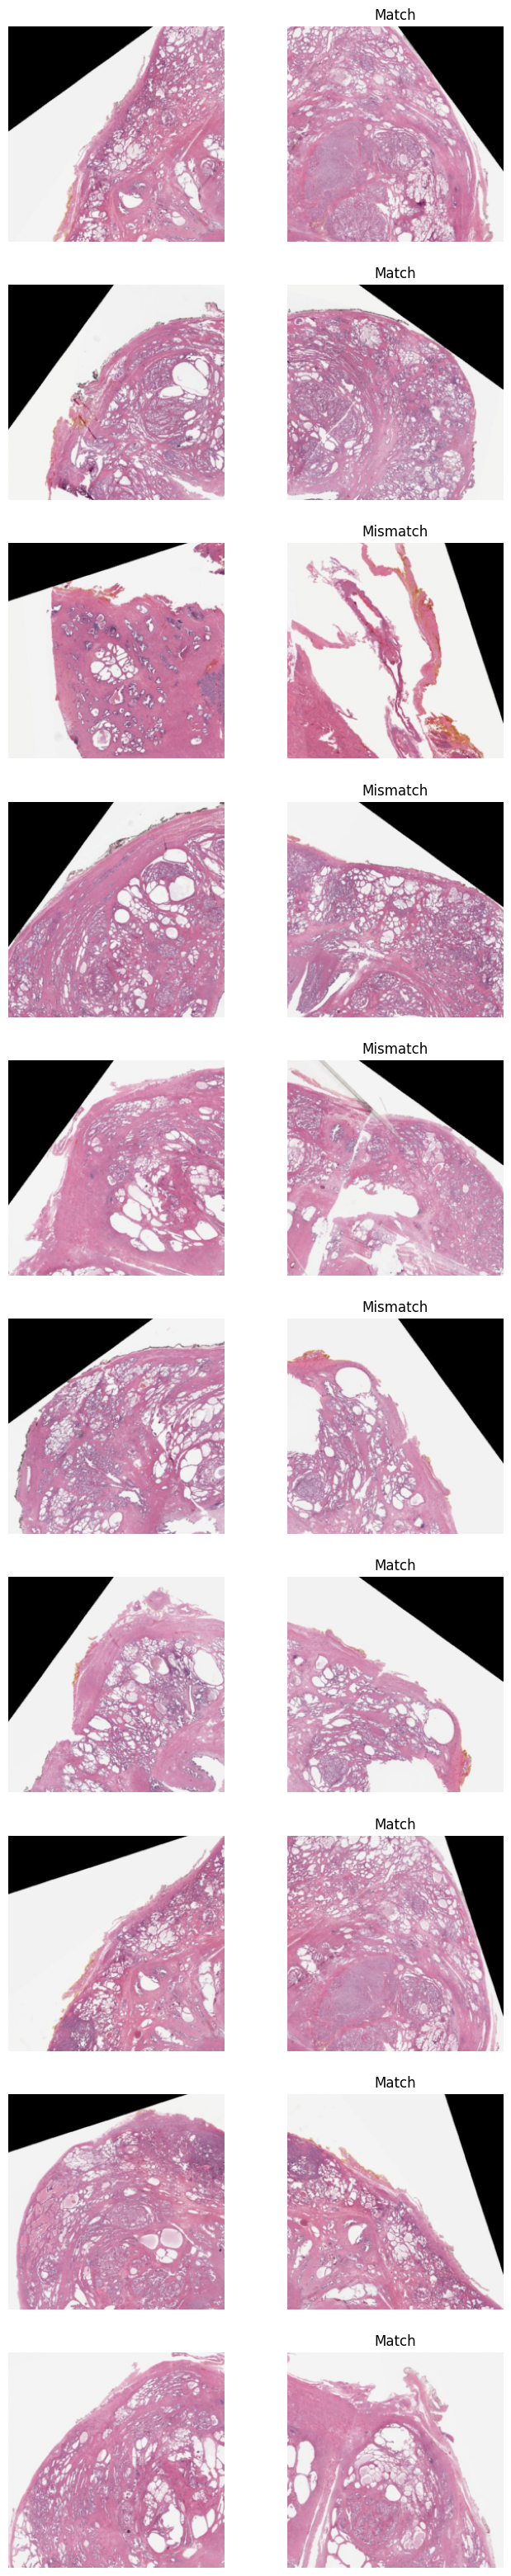

In [201]:
img_dir = Path("/Users/richardgaus/github/histopathology-reconstruction/data/processed/Fragments")
list_IDs = np.arange(start=1, stop=10)

dataset = CustomImageDataset(img_dir=img_dir, list_IDs=list_IDs)
figure = plt.figure(figsize=(8, 40))
cols, rows = 2, 10

labels = {
    0: 'Mismatch',
    1: 'Match'
}

for i in range(10):
    sample_idx = np.random.choice(list_IDs)
    img_left, img_right, target = dataset[sample_idx]

    figure.add_subplot(rows, cols, 2*i+1)
    plt.axis("off")
    plt.imshow(img_left.permute(1, 2, 0))
    figure.add_subplot(rows, cols, 2*i+2)
    plt.axis("off")
    plt.imshow(img_right.permute(1, 2, 0))
    
    plt.title(labels[int(target[0].item())])
plt.show()